In [1]:
from collections import defaultdict

import torch
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from ns_loss import NSLoss

In [2]:
def get_nr_parameters(model):
    totalCount = 0

    for param in model.parameters():
        totalCount += param.nelement()

    return totalCount

In [15]:
class Sine(torch.nn.Module):
    def __init__(self, w0=1):
        super().__init__()
        self.w0 = w0
    def forward(self, x):
        return torch.sin(self.w0 * x)


class PINN(torch.nn.Module):
    def __init__(self, hidden_size=64, nr_hidden_layer=5, out_dimensions=5, sine_activation=False, w0=1) -> None:
        super().__init__()

        self.input = torch.nn.Linear(3, hidden_size)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(hidden_size, hidden_size) for _ in range(nr_hidden_layer)])
        self.output = torch.nn.Linear(hidden_size, out_dimensions)

        self.activation = Sine(w0) if sine_activation else torch.nn.ReLU()

    def forward(self, coords):
        # Input: x, y, t
        coords = coords.clone().detach().requires_grad_(True) 

        x = self.activation(self.input(coords))

        for layer in self.hidden_layers:
            x = self.activation(layer(x))

        x = self.output(x)
        
        #Output: u, v, w, rho, p
        return x, coords

In [16]:
from experiments.navier_stokes.grid_dataset import GridDataset

dataset = GridDataset("../../data/Case_01/measurements_flow/postProcessing_BL/windspeedMapVectors")

MIN_TIME, MAX_TIME = dataset[0][0][:, 2][0].item(), dataset[-1][0][:, 2][0].item()

train, tmp = random_split(dataset, [0.5, 0.5])
val, test = random_split(tmp, [0.5, 0.5])

train_loader = DataLoader(train, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val, batch_size=1, shuffle=True, num_workers=4)
test_loader = DataLoader(test, batch_size=1, shuffle=True, num_workers=4)

len(train), len(val), len(test)

(624, 312, 312)

In [25]:
model = PINN(nr_hidden_layer=5, hidden_size=64, sine_activation=False).cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.LBFGS(model.parameters(), 
                              max_iter=10,
                              tolerance_grad=1e-5,
                              line_search_fn="strong_wolfe"
                            )

criterion = NSLoss(physics_coef=10)

get_nr_parameters(model), model

(21381,
 PINN(
   (input): Linear(in_features=3, out_features=64, bias=True)
   (hidden_layers): ModuleList(
     (0-4): 5 x Linear(in_features=64, out_features=64, bias=True)
   )
   (output): Linear(in_features=64, out_features=5, bias=True)
   (activation): ReLU()
 ))

In [26]:
epochs = 2

train_losses = defaultdict(list)
val_losses = defaultdict(list)

for epoch in tqdm(range(1, epochs+1)):
    running_train_losses = defaultdict(list)
    
    for inputs, targets in tqdm(train_loader):
        model.train()

        inputs = inputs.flatten(0, 1).float().cuda(non_blocking=True)
        targets = targets.flatten(0, 1).float().cuda(non_blocking=True)

        inputs[:, :2] = inputs[:, :2] / 299
        inputs[:, 2] = (inputs[:, 2] - MIN_TIME) / MAX_TIME

        def closure():            
            optimizer.zero_grad()

            outputs, input_coords = model(inputs)
            loss, data_loss, physics_loss = criterion(input_coords, outputs, targets)

            loss.backward()

            running_train_losses['total'].append(loss.item())
            running_train_losses['data'].append(data_loss.item())
            running_train_losses['physics'].append(physics_loss.item())

            return loss
        
        optimizer.step(closure)

    train_losses['total'].append(np.mean(running_train_losses['total']))
    train_losses['data'].append(np.mean(running_train_losses['data']))
    train_losses['physics'].append(np.mean(running_train_losses['physics']))

    running_val_losses = defaultdict(list)

    for inputs, targets in val_loader:
        model.eval()

        inputs = inputs.flatten(0, 1).float().cuda(non_blocking=True)
        targets = targets.flatten(0, 1).float().cuda(non_blocking=True)

        inputs[:, :2] = inputs[:, :2] / 299
        inputs[:, 2] = (inputs[:, 2] - MIN_TIME) / MAX_TIME

        outputs, input_coords = model(inputs)
        loss, data_loss, physics_loss = criterion(input_coords, outputs, targets)

        running_val_losses['total'].append(loss.item())
        running_val_losses['data'].append(data_loss.item())
        running_val_losses['physics'].append(physics_loss.item())

    val_losses['total'].append(np.mean(running_val_losses['total']))
    val_losses['data'].append(np.mean(running_val_losses['data']))
    val_losses['physics'].append(np.mean(running_val_losses['physics']))

    print(f"Epoch: {epoch} - Train Losses: {train_losses['total'][-1]:.4f}, {train_losses['physics'][-1]*10:.4f} - \
          Val Losses: {val_losses['total'][-1]:.4f}, {val_losses['physics'][-1]*10:.4f}")
            

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
torch.save(model.state_dict(), "model.pt")

In [6]:
model = PINN(out_dimensions=5, sine_activation=False).cuda()

model.load_state_dict(torch.load("model.pt"))

model

PINN(
  (input): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-4): 5 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=5, bias=True)
  (activation): ReLU()
)

In [29]:
def get_coordinates(index):
    i = index // 300
    j = index % 300
    return i, j

x,y = get_coordinates(torch.arange(90000))

coords = torch.stack([x, y]).T.cuda() / 299

In [32]:
model.eval()
grids = []

with torch.no_grad():
    for time_instance in torch.linspace(0, 0.2, 100):
        time_tensor = torch.full((coords.shape[0], 1), time_instance).cuda()
        test_input = torch.concat((coords, time_tensor), dim=1)
        
        pred, _ = model(test_input)
        pred_u = pred.reshape(300, 300, 5)[:, :, 1]
        grids.append(pred_u)

grids = torch.stack(grids)

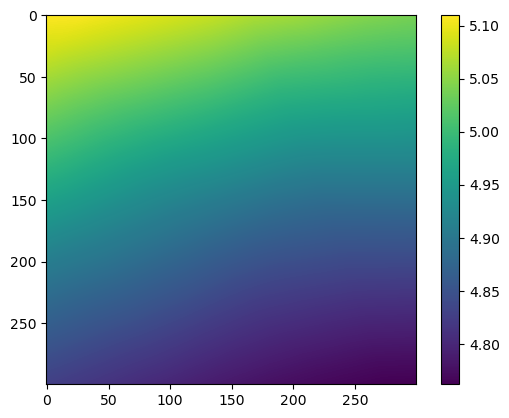

In [37]:
fig, ax = plt.subplots()

im = ax.imshow(grids[99].cpu())

fig.colorbar(im);

#fig.savefig("model output.png")